<a href="https://colab.research.google.com/github/tomonori-masui/entity-resolution/blob/main/entity_resolution_implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entity Resolution - Identifying Real-World Entities in Noisy Data
### Fundamental Theories and Python Implementations

In this notebook, we will explore the technical details of fundamental entity resolution approaches using a benchmark dataset.

## Table of Contents
- [Overview of Entity Resolution](#overview-of-entity-resolution)
- [Benchmark Dataset](#benchmark-dataset)
- [Blocking](#blocking)
- [Block Processing](#block-processing)
- [Entity Matching](#entity-matching)
- [Clustering](#clustering)
- [Cluster Evaluation](#cluster-evaluation)
- [References](#references)

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = None

# Overview of Entity Resolution <a class="anchor" id="overview-of-entity-resolution"></a>
The standard entity resolution (ER) framework consists of several steps: blocking, block processing, entity matching, and clustering.

**1. Blocking**: This is the first step in entity resolution and aims to reduce the search space to identify the same entity by dividing the dataset into smaller, manageable blocks. These blocks contain records that share similar attributes, making the subsequent comparison more efficient.

**2. Block Processing**: This step refines the blocks to minimize the number of comparisons by discarding two types of unnecessary comparisons: the redundant ones, which are repeated across multiple blocks, and the superfluous ones, which involve records unlikely to match.

**3. Entity Matching**: This focuses on comparing records within blocks to find matches based on the similarity of the records. Various similarity metrics and matching algorithms   can be employed to classify pairs of records as matches or non-matches.

**4. Clustering**: Clustering involves grouping the matched records into clusters based on their similarity. The created clusters can be used to get a consolidated view of entities.

<center><img src="https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/images/01_er_workflow.png" width="750" align="center">
</center>
<center>Entity Resolution workflow</center>

# Benchmark Dataset <a class="anchor" id="benchmark-dataset"></a>
In the following sections, we will dive into more details of each step in the entity resolution process, along with Python implementation using a benchmark dataset.
The dataset, sourced from [the database group at the University of Leipzig](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution), is derived from actual records concerning songs from the [MusicBrainz](https://musicbrainz.org/) database but has been deliberately altered using [the DAPO data pollution tool](https://vsis-www.informatik.uni-hamburg.de/getDoc.php/publications/568/Panse-TBD2021-Preprint.pdf). This tool injects both duplicates and errors into the dataset, resulting in a situation where it contains duplicates for 50% of the original records in two to five sources. These duplicates have been generated with a high degree of corruption, serving as a rigorous test to evaluate the effectiveness of ER and clustering approaches.

We can load the data with the following code.

In [2]:
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/data/musicbrainz_200k.csv"
res = requests.get(url)
df = pd.read_csv(BytesIO(res.content))

In [3]:
df.shape

(193750, 12)

Some example records look like something below.

In [4]:
df[df.CID == 41689]

,TID,CID,CTID,SourceID,id,number,title,length,artist,album,year,language
57699,57700,41689,3,4,14690-A031,6,006-My Father,3m 19sec,Bill Cosby,When I Was a Kid (2005),NaN,Eng.
80716,80717,41689,1,2,MBox281897-HH,6,Bill Cosby - My Father,199,NaN,When I Wa sa Kid,05,English
116076,116077,41689,2,3,4534714MB-01,6,My Father - When I Was a Kid,3.325,Bill-Cosby,NaN,'05,ENGLISH


Each record represents a song having attributes such as artist, title, album, year, etc (You can find field descriptions [in this link](https://www.informatik.uni-leipzig.de/~saeedi/musicBrainz_readme.txt)). `CID` is cluster ID and the records having the same `CID` are duplicates (in the example above all three records represent the same song). Our goal is to identify those duplicates in this noisy dataset.

To simplify our work, we are focusing only on English songs. The code below identifies records with cluster IDs that have English songs.

In [5]:
english_cids = df[
    df.language.str.lower().str.contains("^en|^eg", na=False)
].CID.unique()

df = df[df.CID.isin(english_cids)].reset_index(drop=True)

We are also preprocessing some of the string fields to get standardized values.

In [6]:
for col in ["title", "artist", "album"]:
    df[col] = (
        df[col]
        .str.lower()
        .replace("[^a-z0-9]", " ", regex=True)  # replacing special characters with a space
        .replace(" +", " ", regex=True)         # removing consecutive spaces
        .str.strip()                            # removing leading and tailing spaces
    )

df.loc[df.number.notna(), "number"] = (
    df[df.number.notna()]
    .number.replace("[^0-9]", "", regex=True)              # removing non-digits
    .apply(lambda x: str(int(x)) if len(x) > 0 else None)  # removing leading zeros
)

Please note that this benchmark dataset is a single dataset, and if you have multiple data sources for which you want to resolve entities, you need to standardize their data schemas and consolidate these multiple data sources into a unified dataset before proceeding with the subsequent steps.

# Blocking <a class="anchor" id="blocking"></a>
Blocking is the first step in entity resolution that groups similar records together based on certain attributes. By doing so, the process narrows its search to only consider comparisons within each block, rather than examining all possible record pairs in the dataset. This significantly reduces the number of comparisons and accelerates the ER process. As it skips many comparisons, it possibly leads to missed true matches. Therefore, Blocking should achieve a good balance between efficiency and accuracy. In this section, we will explore three different blocking approaches (standard blocking, token blocking, and sorted neighborhood) to find the best balance on that trade-off.

## Standard Blocking
The most straightforward blocking technique involves partitioning the dataset into blocks based on a specific attribute. For example, in our dataset, one might create blocks based on `Artist` or `Title` field. This approach is intuitive and easy to implement, but its effectiveness is very sensitive to noise, as the slightest difference in the blocking keys of duplicates places them in different blocks.

<img src="https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/images/02_standard_blocking.png" width="750" align="center">
<center>Example of Standard Blocking on Artist field</center>

We can get standard blocks with the function below. The dictionary blockswill store blocking keys (`key`) and their corresponding indices (`idx`) of blocked records.

In [7]:
from collections import defaultdict

def standard_blocking(field_values: pd.Series) -> dict[str, list]:

    blocks = defaultdict(list)
    for idx, key in enumerate(field_values):
        if key is not None:
            blocks[key].append(idx)

    return blocks

In the following code, we are creating three independent standard blocks using the fields of `title`, `artist`, and `album`.

In [8]:
sb_title = standard_blocking(df.title)
sb_artist = standard_blocking(df.artist)
sb_album = standard_blocking(df.album)

## Token Blocking
Token blocking focuses on breaking down (i.e. tokenizing) the values of attributes into smaller units, called tokens, and then using these tokens to create blocks for comparison. Tokens are typically single words or small n-grams (substrings of length `n`) extracted from the text. Token blocking creates a block for every distinct token value, regardless of the associated attributes: two records will be in the same block if they share a token in any of their attributes. This yields high recall, due to redundancy (i.e. a single record can belong to multiple blocks), at the cost of low precision.

<center><img src="https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/images/03_token_blocking.png" width="550" align="center"></center>
<center>Example of Token Blocking</center>

The function below generates token blocks based on word tokens. Please note we are excluding stop words (e.g. "a", "the", "is", etc) from the tokens.

In [9]:
%%capture

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

In [10]:
def token_blocking(df: pd.DataFrame, stop_words: set) -> dict[str, list]:

    blocks = defaultdict(list)

    for i, row in enumerate(df.itertuples()):

        # concatenate columns and tokenize
        string = " ".join([str(value) for value in row if not pd.isna(value)])
        tokens = set(
            [word for word in word_tokenize(string) if word not in stop_words]
        )

        # create blocks
        for token in tokens:
            blocks[token].append(i)

    return blocks

As we know which fields are relevant to create blocks, we only use specific fields (`title`, `artist`, and `album`) to perform token blocking:

In [11]:
columns = ['title', 'artist', 'album']
stop_words = set(stopwords.words('english') + list(string.punctuation))
token_blocks = token_blocking(df[columns], stop_words)

## Sorted Neighborhood
Sorted Neighborhood sorts records by specific fields' values in alphabetical order. A fixed-size window slides over the sorted records and all the possible pairs within the window are identified as candidate pairs for comparison. Please note that it directly produces a list of pairs instead of blocks. While this method effectively handles noise in blocking fields, opting for a smaller window sacrifices recall in favor of precision, whereas a larger window has higher recall with lower precision.

<center><img src="https://raw.githubusercontent.com/tomonori-masui/entity-resolution/main/images/04_sorted_neighborhood.gif" width="750" align="center"></center>
<center>Example of Sorted Neighborhood with window size 3</center>

The code below performs Sorted Neighborhood with window size 3, using the fields of `title`, `artist`, and `album` as the sorting keys.

In [12]:
def sorted_neighborhood(
    df: pd.DataFrame, keys: list, window_size: int = 3
) -> np.ndarray:

    sorted_indices = (
        df[keys].dropna(how="all").sort_values(keys).index.tolist()
    )
    pairs = []
    for window_end in range(1, len(sorted_indices)):
        window_start = max(0, window_end - window_size)
        for i in range(window_start, window_end):
            pairs.append([sorted_indices[i], sorted_indices[window_end]])

    return np.array(pairs)

In [13]:
columns = ['title', 'artist', 'album']
sn_pairs = sorted_neighborhood(df, columns)

We will compare the performance of the three approaches discussed in this section after performing block processing and entity matching in the next two sections.

# Block Processing <a class="anchor" id="block-processing"></a>
This step aims to improve the precision of blocks while maintaining a comparable level of recall. The relevant techniques involve reducing unnecessary and redundant comparisons within the input set of blocks `B`, resulting in generation of a new set of blocks `B′` with improved precision. We will explore some of the major block-processing techniques in this section.

## Block Purging
Block Purging sets an upper limit on the block size and purges blocks if their sizes go over the limit. It assumes that excessively large blocks are dominated by redundant comparisons, meaning that duplicates contained in those blocks are more likely to appear in other smaller blocks.
The code below purges blocks by a predetermined limit (set as 1000 records here). It also filters out blocks with just one record as they do not create pairs to compare. We are performing this `purge_blocks` function on the three standard blocks and the token blocks from the previous section.

In [14]:
def purge_blocks(
    blocks: dict[str, list], purging_threshold: int = 1000
) -> dict[str, list]:

    blocks_purged = {
        key: indices
        for key, indices in blocks.items()
        if len(indices) < purging_threshold and len(indices) > 1
    }

    return blocks_purged

In [15]:
token_blocks = purge_blocks(token_blocks)
sb_title = purge_blocks(sb_title)
sb_artist = purge_blocks(sb_artist)
sb_album = purge_blocks(sb_album)

## Meta-blocking
Meta-blocking transforms the input block collection into a graph (or adjacency matrix), where each node corresponds to a record, and edges link every pair of records that co-occur in a block. An edge weight represents the frequency of pair occurrences across blocks: higher weights indicate a greater likelihood of a match. Edges with low weights are pruned, as they likely represent superfluous comparisons. Consequently, for each retained edge, a new block is generated, resulting in a refined block collection (or a list of pairs as each of the refined blocks only has a single pair of records).

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/05_meta_blocking.png?raw=true" width="750" align="center"></center>
<center>Example of Meta Blocking</center>

We are performing meta-blocking only on token blocks as they have many overlaps across the blocks. The following code creates a list of pairs from the token blocks first and then converts it into an adjacency matrix.

In [16]:
import itertools
from scipy.sparse import csr_matrix


def get_pairs_from_blocks(blocks: dict[str, list]) -> list[list]:
    return [
        pair
        for indices in blocks.values()
        for pair in list(itertools.combinations(indices, 2))
    ]


def get_adjacency_matrix_from_pairs(
    pairs: list[list], matrix_shape: tuple[int, int]
) -> csr_matrix:

    idx1 = [pair[0] for pair in pairs]
    idx2 = [pair[1] for pair in pairs]
    ones = np.ones(len(idx1))

    return csr_matrix(
        (ones, (idx1, idx2)), shape=matrix_shape, dtype=np.int8
    )


pairs = get_pairs_from_blocks(token_blocks)
adj_matrix = get_adjacency_matrix_from_pairs(pairs, (len(df), len(df)))

Next, we are pruning edges in the adjacency matrix based on the edge weight. Here we are pruning all edges with edge weight 1, meaning pairs that only appear in a single block are trimmed.

In [17]:
def prune_edges(
    adj_matrix: csr_matrix,
    edge_weight_threshold: float,
    verbose: bool = False,
) -> csr_matrix:

    adj_matrix_pruned = adj_matrix >= edge_weight_threshold

    if verbose:
        print(f"original edge count: {adj_matrix.nonzero()[0].shape[0]:,}")
        print(
            f"edge count after pruning: {adj_matrix_pruned.nonzero()[0].shape[0]:,}"
        )

    return adj_matrix_pruned

adj_matrix = prune_edges(adj_matrix, edge_weight_threshold=2, verbose=True)

original edge count: 70,337,023
edge count after pruning: 2,501,622


Then, we get pairs from the pruned adjacency matrix.

In [18]:
def get_pairs_from_adj_matrix(adjacency_matrix: csr_matrix) -> np.ndarray:
    return np.array(adjacency_matrix.nonzero()).T

tb_pairs = get_pairs_from_adj_matrix(adj_matrix)

## Union of Blocks
In the case of the standard blocks, we obtain a union of the three independent blocks. First, we convert the blocks into a list of adjacency matrices.

In [19]:
adj_matrix_list = []
for blocks in [sb_title, sb_artist, sb_album]:
    pairs = get_pairs_from_blocks(blocks)
    adj_matrix_list.append(
        get_adjacency_matrix_from_pairs(pairs, (len(df), len(df)))
    )

Then, we get a union of the matrices and candidate pairs from it.

In [20]:
def get_union_of_adj_matrices(adj_matrix_list: list) -> csr_matrix:

    adj_matrix = csr_matrix(adj_matrix_list[0].shape)
    for matrix in adj_matrix_list:
        adj_matrix += matrix

    return adj_matrix

In [21]:
adj_matrix_union = get_union_of_adj_matrices(adj_matrix_list)
sb_pairs = get_pairs_from_adj_matrix(adj_matrix_union)

The table below summarizes the final number of candidate pairs from the three different blocking approaches.

In [22]:
pd.DataFrame(
    [
        ["Standard Blocking", f"{len(sb_pairs):,}"],
        ["Token Blocking", f"{len(tb_pairs):,}"],
        ["Sorted Neighborhood", f"{len(sn_pairs):,}"],
    ],
    columns=["Blocking Approach", "N of Candidate Pairs"]
)

,Blocking Approach,N of Candidate Pairs
0,Standard Blocking,"1,338,965"
1,Token Blocking,"2,501,622"
2,Sorted Neighborhood,"382,296"


We will determine which one is the best for our data by looking at a matching result in the next section.

# Entity Matching <a class="anchor" id="entity-matching"></a>
In this step, we identify matched pairs from the candidate pairs generated in the previous step. While there are various methods to find matches, one straightforward approach can be outlined as follows:


**1. Measure similarity on each attribute**

You can use any similarity metrics such as cosine similarity, Jaccard similarity, or Levenshtein distance similarity, based on suitability for your data or specific requirements. Text fields may want to be tokenized before computing similarity for some of the metrics.

**2. Compute overall similarity**

This step combines the per-attribute similarities into an overall similarity score either by applying manually defined rules or utilizing a machine learning model trained on labeled data if available.

**3. Determine matches**

A similarity threshold is applied to the overall similarity score to find matches

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/06_entity_matching.png?raw=true" width="750" align="center"></center>
<center>Example of Entity Matching</center>

The function `get_field_similarity_scores` below takes care of the step 1 above. If `sim_type` is set to `"fuzzy"`, it calculates [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity); otherwise, it performs an exact match. The cosine similarity is calculated on character level 3-grams which are vectorized from input strings using the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) module from scikit-learn. We compute the cosine similarity for the fields of `title`, `artist`, and `album`, while performing an exact match on `number` field.

In [23]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


def get_field_similarity_scores(
    df: pd.DataFrame, pairs: np.ndarray, field_config: dict[str, str]
) -> dict[str, np.ndarray]:
    """
    Measuring similarity by field. It is either cosine similarity
    (if sim_type == 'fuzzy') or exact match 0/1 (if sim_type == 'exact').
    Attribute's similarity scores are stored in field_score dictionary
    with the field name as key.
    """

    field_scores = {}

    for field, sim_type in field_config.items():
        if sim_type == "fuzzy":
            field_scores[field] = cosine_similarities(
                df[field].fillna(""), pairs
            )
        else:
            field_scores[field] = exact_matches(df[field], pairs)

    return field_scores

def cosine_similarities(
    field_values: pd.Series, pairs: np.ndarray
) -> np.ndarray:
    """
    Computing cosine similarities on pairs
    """

    token_matrix_1, token_matrix_2 = get_token_matrix_pair(
        field_values, pairs
    )
    cos_sim = cosine_similarities_on_pair_matrices(
        token_matrix_1, token_matrix_2
    )

    return cos_sim

def get_token_matrix_pair(
    field_values: pd.Series, pairs: np.ndarray,
) -> tuple[csr_matrix, csr_matrix]:
    """
    Converting pairs into matrices of token counts (matrix of records
    by tokens filled with token counts).
    """

    all_idx = np.unique(pairs)
    vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
    vectorizer.fit(field_values.loc[all_idx])
    token_matrix_1 = vectorizer.transform(field_values.loc[pairs[:, 0]])
    token_matrix_2 = vectorizer.transform(field_values.loc[pairs[:, 1]])

    return token_matrix_1, token_matrix_2

def cosine_similarities_on_pair_matrices(
    token_matrix_1: csr_matrix, token_matrix_2: csr_matrix
) -> np.ndarray:
    """
    Computing cosine similarities on pair of token count matrices.
    It normalizes each record (axis=1) first, then computes dot product
    for each pair of records.
    """

    token_matrix_1 = normalize(token_matrix_1, axis=1)
    token_matrix_2 = normalize(token_matrix_2, axis=1)
    cos_sim = np.asarray(
        token_matrix_1.multiply(token_matrix_2).sum(axis=1)
    ).flatten()

    return cos_sim

def exact_matches(
    field_values: pd.Series, pairs: np.ndarray
) -> np.ndarray:
    """
    Performing exact matches on pairs
    """

    arr1 = field_values.loc[pairs[:, 0]].values
    arr2 = field_values.loc[pairs[:, 1]].values

    return ((arr1 == arr2) & (~pd.isna(arr1)) & (~pd.isna(arr2))).astype(int)

In [24]:
field_config = {
    # <field>: <sim_type>
    "title": "fuzzy",
    "artist": "fuzzy",
    "album": "fuzzy",
    "number": "exact",
}

field_scores_sb = get_field_similarity_scores(df, sb_pairs, field_config)

## Rule-based matching

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/07_rule_based_matching.png?raw=true" width="750"></center>
<center>Rule-based matching</center>

After computing field-specific similarity scores, we want to combine them into an overall similarity score, as outlined in step 2 above. We perform a very simple approach here: we just calculate the average of the attributes' scores, and subsequently, we apply a score threshold to identify matches (step 3). The threshold value below is already tuned here, but you may want to tune it by looking at some examples of matched/unmatched pairs when you work on your own dataset.

In [25]:
def calc_overall_scores(field_scores: dict[str, np.ndarray]) -> np.ndarray:
    return np.array(list(field_scores.values())).mean(axis=0)

def find_matches(scores: np.ndarray, threshold: float) -> np.ndarray:
    return scores >= threshold


In [26]:
scores_sb = calc_overall_scores(field_scores_sb)
is_matched_sb = find_matches(scores_sb, threshold=0.64)

The code above performs matching on the pairs from the standard block. Additionally, we extend this matching process to the pairs from the token block and the sorted neighborhood, allowing us to compare their performances.

In [27]:
field_scores_tb = get_field_similarity_scores(df, tb_pairs, field_config)
scores_tb = calc_overall_scores(field_scores_tb)
is_matched_tb = find_matches(scores_tb, threshold=0.64)

In [28]:
field_scores_sn = get_field_similarity_scores(df, sn_pairs, field_config)
scores_sn = calc_overall_scores(field_scores_sn)
is_matched_sn = find_matches(scores_sn, threshold=0.64)

The code below summarizes the comparison in a table.

In [29]:
from IPython.display import display
from collections import Counter

def show_results(
    is_matched_list: list[np.ndarray],
    blocking_approach_name_list: list[str],
):

    result = pd.DataFrame(
        [Counter(is_matched).values() for is_matched in is_matched_list],
        columns=["Unmatch", "Match"],
    )
    result["Blocking Approach"] = blocking_approach_name_list
    result["Matching Rate"] = result.Match / (
        result.Match + result.Unmatch
    )
    result["Matching Rate"] = result["Matching Rate"].map("{:.1%}".format)
    result["Match"] = result["Match"].map("{:,}".format)
    result["Unmatch"] = result["Unmatch"].map("{:,}".format)

    display(
        result[["Blocking Approach", "Match", "Unmatch", "Matching Rate"]]
    )

In [30]:
is_matched_list = [is_matched_sb, is_matched_tb, is_matched_sn]
blocking_approach_name_list = [
    "Standard Blocking",
    "Token Blocking",
    "Sorted Neighborhood",
]
show_results(is_matched_list, blocking_approach_name_list)

,Blocking Approach,Match,Unmatch,Matching Rate
0,Standard Blocking,"58,303","1,280,662",4.4%
1,Token Blocking,"66,765","2,434,857",2.7%
2,Sorted Neighborhood,"23,875","358,421",6.2%


As you can see in the table, Token Blocking yields the highest number of matches, while Sorted Neighborhood has the highest matching rate. As Token Blocking likely has the fewest missed matches, we will proceed with the outcome from this approach. It is worth noting that our small dataset does not present scalability concerns. However, for larger datasets where Token Blocking may not be feasible, you may want to consider the other more scalable approaches.

## Machine-learning matching

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/08_machine_learning_matching_.png?raw=true" width="750"></center>
<center>Machine-learning matching</center>

If you have labeled data or have manually labeled sample pairs as matches or non-matches, you can train a machine-learning model to predict matched pairs. As our data has cluster labels `CID`, we will convert these into matching labels (match/unmatch) for pairs and train a machine-learning model, subsequently comparing its performance with the rule-based approach performed in the previous section.

The following code generates the model input `X` and the corresponding target variable `y`. Pairs within the same cluster `CID` are designated as matches (`y = 1`), while pairs outside the same cluster are labeled as non-matches (`y = 0`).

In [31]:
def get_x_y(
    field_scores: dict[str, np.ndarray],
    pairs: np.ndarray,
    df: pd.DataFrame,
) -> tuple[pd.DataFrame, np.ndarray]:

    X = pd.DataFrame(field_scores)
    y = df.loc[pairs[:, 0], "CID"].values == df.loc[pairs[:, 1], "CID"].values

    return X, y

X, y = get_x_y(field_scores_tb, tb_pairs, df)

Next, we split them into training and testing sets, followed by training a logistic regression model.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

model = LogisticRegression(random_state=0).fit(X_train, y_train)

The code below compares its performance ([`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)) with the rule-based  approach.

In [33]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
print(f"Model f1_score: {f1_score(y_test, y_pred):.3f}")

y_rule_base = is_matched_tb[X_test.index.values]
print(f"Rule-base f1_score: {f1_score(y_test, y_rule_base):.3f}")

Model f1_score: 0.866
Rule-base f1_score: 0.721


While the model's performance is better, the performance of the rule-based approach may still be reasonably good.

For the following steps, we will use matches identified through the rule-based approach, considering that in many real-world cases, manual data labeling might not be practical due to resource constraints. The code below extracts matched pairs and their similarity scores from the candidate pairs and their scores on token blocking.

In [34]:
matched_pairs = tb_pairs[is_matched_tb]
matched_scores = scores_tb[is_matched_tb]

# Clustering <a class="anchor" id="clustering"></a>
In this step, we are creating entity clusters based on the matched pairs from the previous step. Each cluster includes all records corresponding to a distinct real-world entity.

Clustering for entity resolution has several requirements:

**1. Unconstrained algorithm**

The algorithms should not require any domain-specific parameters as input, such as the number of clusters or the diameter of the clusters.

**2. Capability of handling an incomplete similarity matrix**

As the entity resolution process does not compute similarity on every possible pair (which could be described as an N by N matrix), the algorithms must be able to handle an incomplete similarity matrix (or a list of matched pairs).

**3. Scalability**

Entity resolution often handles sizable datasets, making it important that algorithms are capable of handling such data. In cases of large data, algorithms having high complexity like hierarchical clustering might not be practical.

For the clustering, we will examine three major single-pass clustering algorithms: Partitioning (i.e. connected components), Center Clustering, and Merge-Center Clustering, all of which satisfy the requirements. These algorithms are highly efficient as they create clusters by a single scan (or O(n) complexity) of the list of candidate pairs, although some of them require the list to be sorted by similarity score.

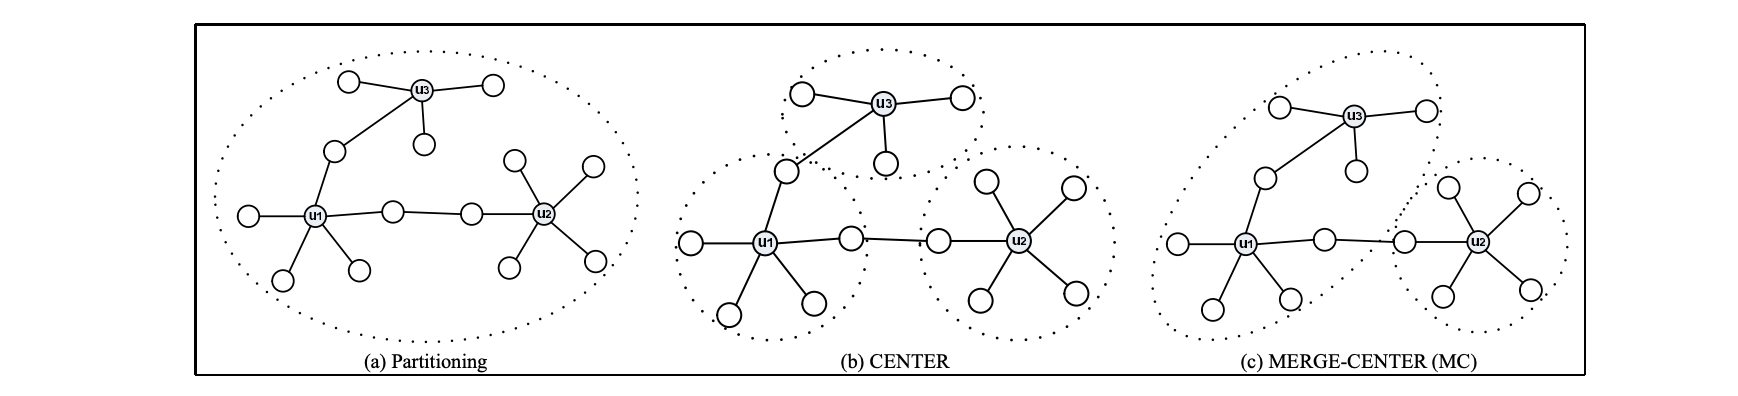
<center>Single-pass clustering algorithms (source: http://www.vldb.org/pvldb/vol2/vldb09-1025.pdf)</center>

## Partitioning/Connected Components
This algorithm initiates clustering by initially assigning each node to its individual cluster. Then, it conducts a single scan of the list of matched pairs. If it identifies connected nodes that do not belong to the same cluster, it merges their clusters. In short, it forms a cluster by grouping all the connected nodes via edges (i.e. matched records via pairs). The algorithm may create clusters that connect dissimilar records via long paths.

Connected components clustering can be performed using the Scipy module as you can see in the code below. Before performing it, you want to convert the list of pairs into an adjacency matrix.

In [35]:
from scipy.sparse.csgraph import connected_components

def connected_components_from_pairs(
    pairs: np.ndarray, dim: int
) -> np.ndarray:

    adjacency_matrix = get_adjacency_matrix_from_pairs(pairs, (dim, dim))
    _, clusters = connected_components(
        csgraph=adjacency_matrix, directed=False, return_labels=True
    )

    return clusters

In [36]:
cc_clusters = connected_components_from_pairs(matched_pairs, len(df))

## Center Clustering
This algorithm [5] performs clustering where each cluster has a center and all records in each cluster are similar to the center of the cluster. It requires the list of similar pairs to be sorted by descending order of similarity scores. The algorithm then performs clustering by a single scan of the sorted list. When a node `u` is encountered for the first time in the scan, it's designated as the cluster center. Any subsequent nodes `v` that are similar to `u` (i.e., appear in a pair `(u, v)` in the list) are assigned to the cluster of `u` and are not considered again during the process.

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/09_center_clustering.gif?raw=true" width="750"></center>
<center>Example of Center Clustering</center>

## Merge-Center Clustering
This algorithm [6] performs similarly to Center clustering, but merges two clusters `cᵢ` and `cⱼ` whenever a record that is similar to the center of the cluster `cᵢ` is similar to the center of `cⱼ`. Note that when two clusters are merged, it does not choose a single center node, which means that merged clusters can have multiple center nodes. This algorithm can be performed similarly by a single scan of the list of similar pairs, but by keeping track of the records that are connected through a merged cluster.

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/10_merge_center_clustering.gif?raw=true" width="750"></center>
<center>Example of Merge-Center Clustering</center>

To perform Center/Merge-Center clustering, we first need to sort the list of pairs by descending order of the similarity scores.

In [37]:
def sort_pairs(pairs: np.ndarray, scores: np.ndarray) -> np.ndarray:
    sorted_ids = (-1 * scores).argsort()
    return pairs[sorted_ids]

pairs_sored = sort_pairs(matched_pairs, matched_scores)

Next, the code below yields two sets of pairs: center-child pairs, denoted as `center_cluster_pairs`, and merged node pairs, referred to as `merge_cluster_pairs`. We can then generate Center clusters and Merge-Center clusters by applying connected components to these lists of pairs.

In [38]:
def get_center_cluster_pairs(pairs, dim):

    """
    cluster_centers:
        list tracking cluster center for each record.
        indices of the list correspond to the original df indices
        and the values represent assigned cluster centers' indices
    center_cluster_pairs:
        list of pairs of indices representing center-child pairs
    merge_cluster_pairs:
        list of pairs of merged nodes' indices
    """
    cluster_centers = [None] * dim
    center_cluster_pairs = []
    merge_cluster_pairs = []

    for idx1, idx2 in pairs:

        if (
            cluster_centers[idx1] is None
            or cluster_centers[idx1] == idx1
            or cluster_centers[idx2] is None
            or cluster_centers[idx2] == idx2
        ):
            # if both aren't child, those nodes are merged
            merge_cluster_pairs.append([idx1, idx2])

        if cluster_centers[idx1] is None and cluster_centers[idx2] is None:
            # if both weren't seen before, idx1 becomes center and idx2 gets child
            cluster_centers[idx1] = idx1
            cluster_centers[idx2] = idx1
            center_cluster_pairs.append([idx1, idx2])
        elif cluster_centers[idx2] is None:
            if cluster_centers[idx1] == idx1:
                # if idx1 is center, idx2 is assigned to that cluster
                cluster_centers[idx2] = idx1
                center_cluster_pairs.append([idx1, idx2])
            else:
                # if idx1 is not center, idx2 becomes new center
                cluster_centers[idx2] = idx2
        elif cluster_centers[idx1] is None:
            if cluster_centers[idx2] == idx2:
                # if idx2 is center, idx1 is assigned to that cluster
                cluster_centers[idx1] = idx2
                center_cluster_pairs.append([idx1, idx2])
            else:
                # if idx2 is not center, idx1 becomes new center
                cluster_centers[idx1] = idx1

    return center_cluster_pairs, merge_cluster_pairs

In [39]:
center_cluster_pairs, merge_cluster_pairs = get_center_cluster_pairs(pairs_sored, len(df))
ct_clusters = connected_components_from_pairs(center_cluster_pairs, len(df))
mc_clusters = connected_components_from_pairs(merge_cluster_pairs, len(df))

# Cluster Evaluation <a class="anchor" id="cluster-evaluation"></a>
As we have the cluster labels, we can evaluate the quality of the clusters using [`Rand Index`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) or [`adjusted Rand Index`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).
Rand Index is a cluster evaluation metric that represents the proportion of pairs that are correctly clustered together or apart. It is defined as follows:

*TP = Number of pairs that are clustered **together** in both predicted and true clusters.*

*TN = Number of pairs that are clustered **apart** in both predicted and true clusters.*

*Rand Index = (TP + TN) / Total number of possible pairs*

<center><img src="https://github.com/tomonori-masui/entity-resolution/blob/main/images/11_rand_index.png?raw=true" width="750"></center>
<center>Example of Rand Index Calculation</center>

Adjusted Rand Index is a modified version of Rand Index that is corrected for chance. The adjustment accounts for the possibility of random agreement from clustering results that were randomly assigned.

$$ Adjusted Index = {Index - Expected Index \over Max Index - Expected Index} $$

We won't delve into how each term in the above equation is calculated here, but anyone who is interested in this topic can refer to [the paper from KY Yeung](https://faculty.washington.edu/kayee/pca/supp.pdf) which explains the metric with some examples.

The code below gives us a comparison of the clusters using those metrics along with some additional basic statistics.

In [40]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
from IPython.display import display

def get_stats(labels, clusters):

    stats = []
    stats.append(f"{rand_score(labels, clusters):.3f}")
    stats.append(f"{adjusted_rand_score(labels, clusters):.3f}")
    clus_dist = pd.Series(clusters).value_counts()
    stats.append(f"{len(clus_dist):,}")
    stats.append(f"{clus_dist.mean():.3f}")
    stats.append(f"{clus_dist.min():,}")
    stats.append(f"{clus_dist.max():,}")

    return stats


def compare_clusters(cluster_list, cluster_names, labels):

    stats_dict = {}
    for clusters, name in zip(cluster_list, cluster_names):
        stats = get_stats(labels, clusters)
        stats_dict[name] = stats

    display(
        pd.DataFrame(
            stats_dict,
            index=[
                "Rand Index",
                "Adjusted Rand Index",
                "Cluster Count",
                "Mean Cluster Size",
                "Min Cluster Size",
                "Max Cluster Size",
            ],
        )
    )

In [41]:
cluster_list = [cc_clusters, ct_clusters, mc_clusters]
cluster_names = ["Connected Components", "Center", "Merge-Center"]
compare_clusters(cluster_list, cluster_names, df.CID)

,Connected Components,Center,Merge-Center
Rand Index,1.000,1.000,1.000
Adjusted Rand Index,0.782,0.591,0.784
Cluster Count,"79,229","90,994","79,267"
Mean Cluster Size,1.609,1.401,1.608
Min Cluster Size,1,1,1
Max Cluster Size,86,6,86


As you can see in the table, connected components produce the larger clusters with the fewest cluster count, while the gap between connected components and the Merge-Center clusters is minimal. Conversely, the Center clusters yield the smaller clusters with the highest count. Please note that all three clusters have a perfect Rand Index, as they have a large numbe of clusters making inter-cluster pairs dominant (i.e. even random clustering yields a respectable Rand Index). However, if you look at the Adjusted Rand Index, Merge-Center clustering is the best, while its difference from connected components is marginal.

That concludes our exploration of the entity resolution framework. How you proceed with the created clusters depends on your specific business requirements or use case. If you aim to establish a canonical representation for each cluster, you can achieve this by extracting the most representative value (such as the most frequent value) for each field within each cluster.

# References <a class="anchor" id="references"></a>
[1] Christophides et al., [End-to-End Entity Resolution for Big Data: A Survey](https://arxiv.org/abs/1905.06397) (2019)

[2] Papadakis et al., [Comparative analysis of approximate blocking techniques for entity resolution](http://www.vldb.org/pvldb/vol9/p684-papadakis.pdf) (2016)

[3] Papadakis et al., [A survey of blocking and filtering techniques for entity resolution](https://arxiv.org/abs/1905.06167) (2020)

[4] Hassanzadeh et al., [Framework for evaluating clustering algorithms in duplicate detection](http://www.vldb.org/pvldb/vol2/vldb09-1025.pdf) (2009)

[5] Haveliwala et al., [Scalable techniques for clustering the web](https://www.researchgate.net/publication/221035516_Scalable_Techniques_for_Clustering_the_Web) (2000)

[6] Hassanzadeh & Miller, [Creating probabilistic databases from duplicated data](https://www.researchgate.net/publication/220473509_Creating_probabilistic_databases_from_duplicated_data) (2009)